In [1]:
# Imports from the helpers folder, containing the lstm code and auxilliary functions
import sys  
sys.path.insert(0, "helpers/")
from lstm import Model, Optimization
from aux_functions import (dateindex_from_weeknum, dateindex_from_timestamp, ts_train_test_split, 
                           cols_with_most_corr, lagged_corr, lagged_corr_matrix, 
                           cols_with_most_lagged_corr, calculate_pvalues, cols_with_sig_pval, corr_feature_selection)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from datetime import datetime, timedelta
# Packages of forecasting models
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)
import pmdarima as pm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/Users/Geri/.local/share/virtualenvs/thesis-ez8c3QqQ/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [2]:
# Daily sales data
milan_data_df = pd.read_csv("../datasets/milan_daily.csv", index_col=[0], parse_dates=True)
turin_data_df = pd.read_csv("../datasets/turin_daily.csv", index_col=[0], parse_dates=True)
rome_data_df = pd.read_csv("../datasets/rome_daily.csv", index_col=[0], parse_dates=True)

print("Milan sales data:", milan_data_df.shape)
print(milan_data_df.head())
print("\n")
print("Turin sales data:", turin_data_df.shape)
print(turin_data_df.head())
print("\n")
print("Rome sales data:", rome_data_df.shape)
print(rome_data_df.head())
print("\n")

# Exogenous weather data
parser = lambda date: datetime.strptime(date, '%d/%m/%Y')
milan_weather_df = pd.read_csv("../datasets/Eso_data/weather/milano_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)
turin_weather_df = pd.read_csv("../datasets/Eso_data/weather/torino_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)
rome_weather_df = pd.read_csv("../datasets/Eso_data/weather/roma_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)

Milan sales data: (1357, 1)
            qty
time           
2016-04-14  119
2016-04-15  119
2016-04-16  206
2016-04-17  211
2016-04-18   85


Turin sales data: (1460, 1)
            qty
time           
2016-01-02  127
2016-01-03  105
2016-01-04   86
2016-01-05  213
2016-01-06  299


Rome sales data: (1460, 1)
            qty
time           
2016-01-02  110
2016-01-03  115
2016-01-04   86
2016-01-05  371
2016-01-06  294




In [3]:
def augment_store_data (store_df, loc_weather_df):
    ## STORE DATA
    store_daily_totals = store_df.copy(deep=True)

    # No pre-processing needed, we are sure there are no missing values for each present day
    day_yearly_nr = np.array(list(map(int, store_daily_totals.index.strftime('%j').tolist())))
    nrm_days = day_yearly_nr/365
    store_daily_totals["sin_day"] =  np.sin((day_yearly_nr/365) * 2*np.pi)
    store_daily_totals["cos_day"] = np.cos((day_yearly_nr/365) * 2*np.pi)
    store_daily_totals["sincos_day"] = np.sin((day_yearly_nr/365) * 2*np.pi) * np.cos((day_yearly_nr/365) * 2*np.pi)
    ## WEATHER DATA
    # We won't be using the following cols (nan vals or categorical)
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "PRESSIONEMEDIA mb", "PIOGGIA mm", "FENOMENI"], axis=1)
    loc_weather_df = loc_weather_df.loc[store_daily_totals.index[0]:,:]
    
    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    store_daily_weather_augmented = store_daily_totals.copy(deep=True)
    for w_col in loc_weather_df.columns:
        store_daily_weather_augmented[w_col] = loc_weather_df.loc[:, w_col]
   
    # Find and replace NAN values in sales and replace them if they are present
    nan_indices = store_daily_weather_augmented[loc_weather_df.isnull().any(axis=1)].index
    for nan_idx in nan_indices:
        n_days_before = nan_idx - timedelta(days=3)
        before_nan = nan_idx - timedelta(days=1)
        store_daily_weather_augmented.fillna(np.mean(store_daily_weather_augmented.loc[n_days_before:before_nan]), inplace=True)

    return store_daily_totals, store_daily_weather_augmented

# Augment single location sales data and then put everything together
milan_daily_default, milan_daily_augmented = augment_store_data(milan_data_df, milan_weather_df)
print("Milan data original shape:", milan_daily_default.shape)
print("Milan + exogenous data shape:", milan_daily_augmented.shape)
turin_daily_default, turin_daily_augmented = augment_store_data(turin_data_df, turin_weather_df)
print("Turin data original shape:", turin_daily_default.shape)
print("Turin + exogenous data shape:", turin_daily_augmented.shape)
rome_daily_default, rome_daily_augmented = augment_store_data(rome_data_df, rome_weather_df)
print("Rome data original shape:", rome_daily_default.shape)
print("Rome + exogenous data shape:", rome_daily_augmented.shape)

Milan data original shape: (1357, 4)
Milan + exogenous data shape: (1357, 14)
Turin data original shape: (1460, 4)
Turin + exogenous data shape: (1460, 14)
Rome data original shape: (1460, 4)
Rome + exogenous data shape: (1460, 14)


In [4]:
## Create dicts for different store data
datasets = {
    "Milan": milan_daily_augmented,
    #"Turin": turin_daily_augmented, 
    #"Rome": rome_daily_augmented
}

# Data Visualization and Exploration 

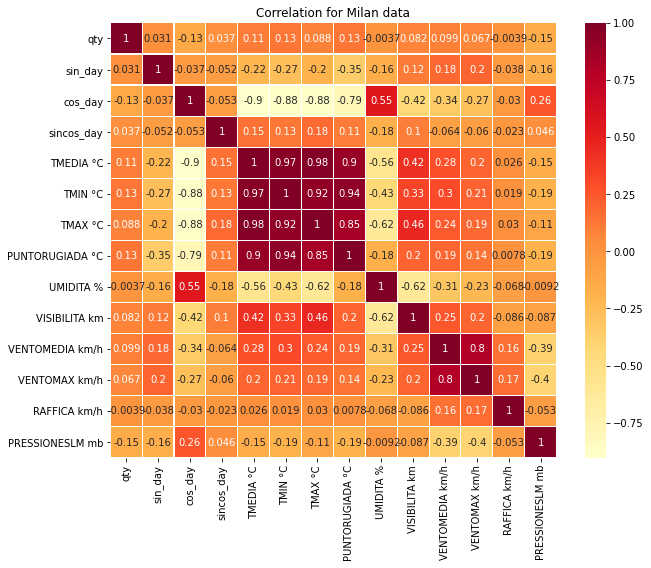

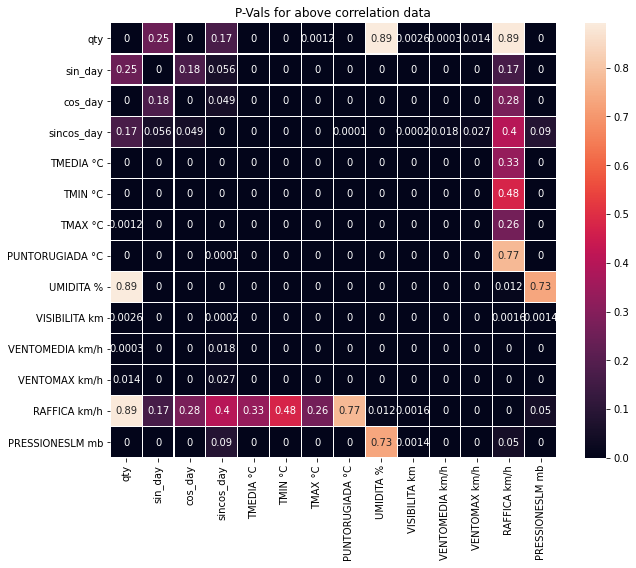

In [5]:
# Correlation in the data with added exogenous variables: Spearman Correlation
for dataset in datasets:    
    default_s_corr = datasets[dataset].corr(method="spearman")
    plt.figure(figsize=(10,8))
    sns.heatmap(data=default_s_corr, cmap="YlOrRd", annot=True, linewidths=.1)
    plt.title("Correlation for "+ dataset+" data")
    plt.show()

    def_p_val_matrix = calculate_pvalues(datasets[dataset], lag=0)
    plt.figure(figsize=(10,8))
    sns.heatmap(data=def_p_val_matrix, annot=True, linewidths=.1)
    plt.title("P-Vals for above correlation data")
    plt.show()

Milan data 

[0.0, 0.2473, 0.0, 0.174, 0.0, 0.0, 0.0012, 0.0, 0.8919, 0.0026, 0.0003, 0.0137, 0.8859, 0.0]


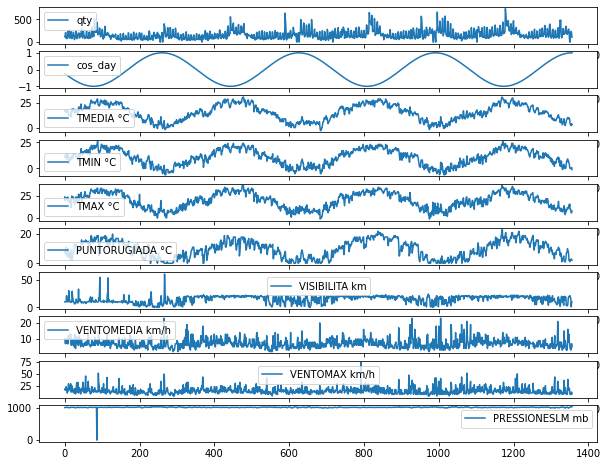

In [6]:
# Plot the data to explore and see what we are working with
for dataset in datasets:
    print(dataset, "data \n")
    # Plot the data with the most correlation to the sales we are trying to predict
    # These are the features we will train the network on later
    values = datasets[dataset].values
    cols_to_plot = cols_with_sig_pval(datasets[dataset])
    
    i=1
    plt.figure(figsize=(10,8))
    for col in cols_to_plot:
        plt.subplot(len(cols_to_plot), 1, i)
        plt.plot(values[:, col], label=datasets[dataset].columns[col])
        plt.legend()
        i += 1
    plt.show()

# LSTM helper functions

In [80]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len, out_len):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")

    return inp_tr, out_tr, inp_te, out_te

def prepare_for_network(train, test, input_features, in_len, out_len):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [0,1]
    # We scale all our data in order to build the final training and test dataframes
    
    
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    
    for col in tr_df.columns:
        # Z standartization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std

    # Prepare data for the LSTM Network: We need to create sequences of inputs and outputs
    # so that our time series problem esentially becomes a "supervised regression problem".
    inp_tr, out_tr, inp_te, out_te = build_in_out_seq(tr_df, te_df, input_features, in_len, out_len)
    return inp_tr, out_tr, inp_te, out_te

def define_LSTM_Model(input_features):
    loss_fn = nn.MSELoss()
    LSTM_Model = Model(input_size=len(input_features), hidden_size=256, output_size=len(input_features))
    optimizer = optim.Adam(LSTM_Model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
    opt_obj = Optimization(LSTM_Model, loss_fn, optimizer, scheduler)
    return LSTM_Model, opt_obj

def check_lstm_forecast_results(pred, inp_te, out_te, poll_mean, poll_std, in_len, out_len):
    # Rescales the data back to nrm vals first
    pred_vec = (pred[0,-out_len:,0].detach().cpu().numpy() * poll_std) + poll_mean
    real_vec = (out_te[0,:,0] * poll_std) + poll_mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)
    return rmse, mae

In [8]:
#for dataset in datasets:
#    # Get one hot encoding of columns B
#    one_hot = pd.get_dummies(datasets[dataset]['B'])
#    # Drop column B as it is now encoded
#    datasets[dataset] = df.drop('day_of_week',axis = 1)
#    # Join the encoded df
#    df = df.join(one_hot)

In [9]:
milan_daily_augmented["day_of_week"] = milan_daily_augmented.index.dayofweek

In [10]:
milan_daily_augmented

,qty,sin_day,cos_day,sincos_day,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,PRESSIONESLM mb,day_of_week
time,,,,,,,,,,,,,,,
2016-04-14,119,9.721182e-01,-0.234491,-2.279533e-01,17.0,11.0,24.0,8.0,58.0,10.0,10.0,19.0,0.0,1008.0,3
2016-04-15,119,9.679378e-01,-0.251190,-2.431364e-01,16.0,12.0,20.0,8.0,57.0,10.0,9.0,17.0,0.0,1012.0,4
2016-04-16,206,9.634705e-01,-0.267814,-2.580312e-01,17.0,11.0,21.0,7.0,53.0,10.0,7.0,17.0,0.0,1011.0,5
2016-04-17,211,9.587178e-01,-0.284359,-2.726202e-01,17.0,14.0,21.0,11.0,65.0,10.0,9.0,19.0,0.0,1010.0,6
2016-04-18,85,9.536810e-01,-0.300820,-2.868861e-01,17.0,13.0,23.0,8.0,57.0,10.0,9.0,24.0,33.0,1011.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,194,-6.880243e-02,0.997630,-6.863939e-02,3.0,0.0,10.0,2.0,85.0,17.0,4.0,9.0,0.0,1023.0,4
2019-12-28,228,-5.161967e-02,0.998667,-5.155085e-02,3.0,0.0,9.0,2.0,87.0,16.0,3.0,8.0,0.0,1030.0,5
2019-12-29,233,-3.442161e-02,0.999407,-3.440121e-02,2.0,0.0,6.0,3.0,97.0,1.0,4.0,9.0,0.0,1034.0,6


# Forecasting evaluation

In [81]:
single_run_results = []
n_runs = 1
for dataset in datasets:
    print("Running forecasting for sales in", dataset, "\n")
    for run in range(n_runs):
        print ("Run #", run+1)
        
        # Add day of week as one hot encoded signal before running the lstm model
        full_dataset = datasets[dataset]

        # Create training and test data
        train, test = ts_train_test_split(full_dataset, test_length=0.1)
        print(train.shape, test.shape)

        # Extract the columns which display most correlation with the value we are trying to predict.
        mono_input_features = [0, full_dataset.shape[1]-1, 4]
        exo1_input_features = [0, 1, 2, 3]
        exo2_input_features = [0] + list(range(4,full_dataset.shape[1]))
        exo3_input_features = list(range(0,full_dataset.shape[1]))
        print("MONO-LSTM input features:", mono_input_features)
        print("EXO1 (+ sincos day) input features :", exo1_input_features)
        print("EXO2 (+ weather exog) input features :", exo2_input_features)
        print("EXO3 (+ all exog) input features :", exo3_input_features)
        print()

        # Define steps ahead to forecast
        lstm_in_len = x?
        lstm_out_steps = 14
        f_steps = test.shape[0]
       
        ## Run STL Decomposition as baseline
        print("Running Drift model based on STL Decomposition...")
        decomp = decompose(train.qty, period=365)
        drift_forecast = forecast(decomp, steps=f_steps, fc_func=drift(n=lstm_in_steps), seasonal=True)
        drift_rmse = sm.tools.eval_measures.rmse(test.qty.values[lstm_in_steps:], drift_forecast["drift+seasonal"].values)
        drift_mae = sm.tools.eval_measures.meanabs(test.qty.values[lstm_in_steps:], drift_forecast["drift+seasonal"].values)
        print("Done\n")

        ## Run ARIMA as another baseline
        print("Running ARIMA model...")
        # Fit your model
        arima_model = pm.auto_arima(train.qty, suppress_warnings=True, max_order=None, \
                                    seasonal=True, start_p=3, start_q=0, start_P=0, start_Q=0, \
                                    max_p=6, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1)
        
        # max-min arima p,q for auto-arima
        arima_order = arima_model.get_params()["order"]
        arima_fitted = arima_model.fit(train.qty)
        arima_forecasts = arima_fitted.predict(f_steps)  
        arima_rmse = sm.tools.eval_measures.rmse(test.qty[lstm_in_steps:], arima_forecasts)
        arima_mae = sm.tools.eval_measures.meanabs(test.qty[lstm_in_steps:], arima_forecasts)
        print("Done\n")

        # Run ARIMAX as another baseline
        print("Running ARIMAX model...")
        arimax_fitted = arima_model.fit(y=train.qty, exogenous=train.iloc[:, 1:])
        arimax_forecasts = arimax_fitted.predict(f_steps, exogenous=test.iloc[lstm_in_steps:, 1:])  
        arimax_rmse = sm.tools.eval_measures.rmse(test.qty[lstm_in_steps:], arimax_forecasts)
        arimax_mae = sm.tools.eval_measures.meanabs(test.qty[lstm_in_steps:], arimax_forecasts)
        print("Done\n")

        
        
        ## LSTM
        # Define the LSTM Models and their Optimizer objects
        mono_LSTM_Model, mono_opt_obj = define_LSTM_Model(mono_input_features)
        #exo1_LSTM_Model, exo1_opt_obj = define_LSTM_Model(exo1_input_features)
        #exo2_LSTM_Model, exo2_opt_obj = define_LSTM_Model(exo2_input_features)
        #exo3_LSTM_Model, exo3_opt_obj = define_LSTM_Model(exo3_input_features)
        
        
        # 1) MONO-LSTM data
        mono_inp_tr, mono_out_tr, mono_inp_te, mono_out_te = prepare_for_network(train, test, mono_input_features, in_len=lstm_in_steps, out_len=lstm_out_steps)
        mono_x_train=torch.cat((torch.Tensor(mono_inp_tr),torch.Tensor(mono_out_tr)),1)
        mono_x_test=torch.Tensor(mono_inp_te)

        ## 2) EXO1-LSTM data
        #exo1_inp_tr, exo1_out_tr, exo1_inp_te, exo1_out_te = prepare_for_network(train, test, exo1_input_features, in_len=390, out_len=f_steps)
        #exo1_x_train=torch.cat((torch.Tensor(exo1_inp_tr),torch.Tensor(exo1_out_tr)),1)
        #exo1_x_test=torch.Tensor(exo1_inp_te)
#
        ## 3) EXO2-LSTM data
        #exo2_inp_tr, exo2_out_tr, exo2_inp_te, exo2_out_te = prepare_for_network(train, test, exo2_input_features, in_len=390, out_len=f_steps)
        #exo2_x_train=torch.cat((torch.Tensor(exo2_inp_tr),torch.Tensor(exo2_out_tr)),1)
        #exo2_x_test=torch.Tensor(exo2_inp_te)
#
        ## 4) EXO3-LSTM data
        #exo3_inp_tr, exo3_out_tr, exo3_inp_te, exo3_out_te = prepare_for_network(train, test, exo3_input_features, in_len=390, out_len=f_steps)
        #exo3_x_train=torch.cat((torch.Tensor(exo3_inp_tr),torch.Tensor(exo3_out_tr)),1)
        #exo3_x_test=torch.Tensor(exo3_inp_te)
#
        # Train all the LSTMs 
        print("Training the MONO-LSTM model...")
        mono_opt_obj.train(mono_x_train[:,:-1],mono_x_train[:,1:],mono_x_train[:,:-1],mono_x_train[:,1:], \
                           do_teacher_forcing=True, n_epochs=20, batch_size=128)
        #print("Done\n")
        #print("Training the EXO1-LSTM model...")
        #exo1_opt_obj.train(exo1_x_train[:,:-1],exo1_x_train[:,1:],exo1_x_train[:,:-1],exo1_x_train[:,1:], \
        #                   do_teacher_forcing=True, n_epochs=10+len(exo1_input_features)*3, batch_size=128)
        #print("Done\n")
        #print("Training the EXO2-LSTM model...")
        #exo2_opt_obj.train(exo2_x_train[:,:-1],exo2_x_train[:,1:],exo2_x_train[:,:-1],exo2_x_train[:,1:], \
        #                   do_teacher_forcing=True, n_epochs=10+len(exo2_input_features)*3, batch_size=128)
        #print("Done\n")
        #print("Training the EXO3-LSTM model...")
        #exo3_opt_obj.train(exo3_x_train[:,:-1],exo3_x_train[:,1:],exo3_x_train[:,:-1],exo3_x_train[:,1:], \
        #                   do_teacher_forcing=True, n_epochs=10+len(exo3_input_features)*3, batch_size=128)
        #print("Done\n")
        
        mono_pred_seq = mono_LSTM_Model(mono_x_test, lstm_out_steps)

        # Make predictions using the trained networks
        #mono_pred = mono_LSTM_Model(mono_x_test, f_steps)
        #exo1_pred = exo1_LSTM_Model(exo1_x_test, f_steps)
        #exo2_pred = exo2_LSTM_Model(exo2_x_test, f_steps)
        #exo3_pred = exo3_LSTM_Model(exo3_x_test, f_steps)
        #exo3_pred_mono = exo3_LSTM_Model.predict_mono(exo3_x_test, f_steps, torch.Tensor(exo3_out_te))

        ## Check results of LSTM forecasts (calc erros)
        mean = np.mean(train.qty.values)
        std = np.std(train.qty.values)
        mono_lstm_rmse, mono_lstm_mae = check_lstm_forecast_results(mono_pred_seq, mono_inp_te, mono_out_te, mean, std, in_len=lstm_in_steps, out_len=lstm_out_steps)
        #exo1_lstm_rmse, exo1_lstm_mae = check_lstm_forecast_results(exo1_pred, exo1_inp_te, exo1_out_te, mean, std, in_len=390, out_len=f_steps)
        #exo2_lstm_rmse, exo2_lstm_mae = check_lstm_forecast_results(exo2_pred, exo2_inp_te, exo2_out_te, mean, std, in_len=390, out_len=f_steps)
        #exo3_lstm_rmse, exo3_lstm_mae = check_lstm_forecast_results(exo3_pred, exo3_inp_te, exo3_out_te, mean, std, in_len=390, out_len=f_steps)
        #exo3_lstm_rmse_var, exo3_lstm_mae_var = check_lstm_forecast_results(exo3_pred_mono, exo3_inp_te, exo3_out_te, mean, std, in_len=390, out_len=f_steps)

        
        
        #plt.figure(figsize=(10,8))
        #plt.plot(range(0,42), train.qty[-42:], label="train")
        #plt.plot(range(42,f_steps+42), test.qty, label="test")
        #plt.plot(range(42,f_steps+42), (mono_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean, label="forecast")
        #plt.legend()
        #plt.show()
       
        fig = go.Figure()
        x_labels = list(range(0,f_steps))
        fig.add_trace(go.Scatter(x=x_labels, y=test.qty[-f_steps:],
                    mode='lines', name='GT'))
        fig.add_trace(go.Scatter(x=x_labels, y=drift_forecast["drift+seasonal"].values,
                    mode='lines', name="DRIFT %.2f" % drift_rmse ))
        fig.add_trace(go.Scatter(x=x_labels, y=arima_forecasts,
                    mode='lines', name='ARIMA'+str(arima_order)+"%.2f" % arima_rmse))
        fig.add_trace(go.Scatter(x=x_labels, y=arimax_forecasts,
                    mode='lines', name='ARIMAX'+str(arima_order)+"%.2f" % arimax_rmse))
        fig.add_trace(go.Scatter(x=x_labels, y=(mono_pred_seq[0,:,0].detach().cpu().numpy()*std)+mean,
                     mode='lines', name="MONO-LSTM %.2f" % mono_lstm_rmse ))
        #fig.add_trace(go.Scatter(x=x_labels, y=(exo1_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
        #             mode='lines', name='EXO1-LSTM'))
        #fig.add_trace(go.Scatter(x=x_labels, y=(exo2_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
        #             mode='lines', name='EXO2-LSTM'))
        #fig.add_trace(go.Scatter(x=x_labels, y=(exo3_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
        #             mode='lines', name='EXO3-LSTM'))
        #fig.add_trace(go.Scatter(x=x_labels, y=(exo3_pred_mono[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
        #             mode='lines', name='EXO3-LSTM-NEW'))
        #Update plot title and axis titles, then save plot as a HTML File
        fig.update_layout(
            title="Forecast of test set",
            xaxis_title="Time steps",
            yaxis_title="Prediction",
            font=dict(
                family="Courier New, monospace",
                size=16,
                color="#7f7f7f"
            )
        )
        fig.show()
        #pltio.write_html(fig, dataset+"-"+"run"+str(run+1)+"daily-sales-results.html")
        #single_run_results.append([dataset, "run "+str(run+1), drift_rmse, \
        #                           mono_lstm_rmse, exo1_lstm_rmse, exo2_lstm_rmse, exo3_lstm_rmse, \
        #                           drift_mae, mono_lstm_mae, exo1_lstm_mae, \
        #                           exo2_lstm_mae, exo3_lstm_mae, exo3_lstm_rmse_var, exo3_lstm_mae_var])
        #
        single_run_results.append([dataset, "run "+str(run+1), drift_rmse, \
                                   mono_lstm_rmse, mono_lstm_mae])


        print()

Running forecasting for sales in Milan 

Run # 1
(1222, 15) (135, 15)
MONO-LSTM input features: [0, 14, 4]
EXO1 (+ sincos day) input features : [0, 1, 2, 3]
EXO2 (+ weather exog) input features : [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Running Drift model based on STL Decomposition...


TypeError: drift() missing 1 required positional argument: 'data'

In [77]:
f_steps

93

torch.Size([87, 49, 3])

In [ ]:
# Results for each run of forecasting
#single_run_results_df = pd.DataFrame(single_run_results, 
#                                     columns=["Dataset", "Run Nr.", "DRIFT RMSE", "MONO-LSTM RMSE", "EXO1-LSTM RMSE", \
#                                              "EXO2-LSTM RMSE", "EXO3-LSTM RMSE",\
#                                              "DRIFT MAE", "MONO-LSTM MAE", "EXO1-LSTM MAE", "EXO2-LSTM MAE",\
#                                              "EXO3-LSTM MAE", "NEW EXO3 RMSE", "NEW EXO3 MAE"])
#single_run_results_df

In [ ]:
# Aggregate results
mean_results = single_run_results_df.copy(deep=True)
#mean_results = mean_results.groupby(["Dataset"]).agg(np.mean)
#mean_results

#mean_res = pd.DataFrame(np.mean(mean_results.iloc[:,2:].values), columns=mean_results.columns)
mean_results.mean()


In [ ]:
# Graphic comparison of error values: RMSE
plt.figure(figsize=(10,8))
plt.title("Comparison of RMSE Values of the forecasts")
ax = sns.scatterplot(x=mean_results.index, y="DRIFT RMSE", data=mean_results, label="Drift")
#ax = sns.scatterplot(x=mean_results.index, y="SARIMA RMSE", data=mean_results, label="SARIMA")
#ax = sns.scatterplot(x=mean_results.index, y="SARIMAX RMSE", data=mean_results, label="SARIMAX")
ax = sns.scatterplot(x=mean_results.index, y="MONO-LSTM RMSE", data=mean_results, label="MONOLSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO1-LSTM RMSE", data=mean_results, label="EXO1-LSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO2-LSTM RMSE", data=mean_results, label="EXO2-LSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO3-LSTM RMSE", data=mean_results, label="EXO3-LSTM")
ax.set(ylabel="RMSE")
plt.show()

# Graphic comparison of error values: MAE
plt.figure(figsize=(10,8))
plt.title("Comparison of MAE Values of the forecasts")
aax = sns.scatterplot(x=mean_results.index, y="DRIFT MAE", data=mean_results, label="Drift")
#aax = sns.scatterplot(x=mean_results.index, y="SARIMA MAE", data=mean_results, label="SARIMA")
#aax = sns.scatterplot(x=mean_results.index, y="SARIMAX MAE", data=mean_results, label="SARIMAX")
aax = sns.scatterplot(x=mean_results.index, y="MONO-LSTM MAE", data=mean_results, label="MONOLSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO1-LSTM MAE", data=mean_results, label="EXO1-LSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO2-LSTM MAE", data=mean_results, label="EXO2-LSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO3-LSTM MAE", data=mean_results, label="EXO3-LSTM")
aax.set(ylabel="MAE")
plt.show()

93 (87, 42) (87, 7) (93,)
[117. 149. 150. 142. 125. 161.  97.  81. 101. 110. 121. 120. 170. 133.
  92.  91. 106.  77. 115. 227. 200. 118. 108.  94. 112. 108. 235. 238.
 117.  86.  70.  88. 132. 225. 284. 100.  90.  87. 113. 107. 247. 198.
  89.] [ 89.  78. 100. 106. 136. 254. 283.]
[121. 143. 125. 179. 135. 309. 287. 122. 141. 171. 171. 206. 362. 367.
 156. 105. 118. 155. 158. 298. 277. 134. 108. 112. 143. 383. 398. 269.
 157. 102.  88. 117. 132. 277. 284. 133.  85. 123. 112. 133. 248. 262.
  93.] [ 93. 102. 101. 117. 151. 271. 317.]


IndexError: index 98 is out of bounds for axis 0 with size 87

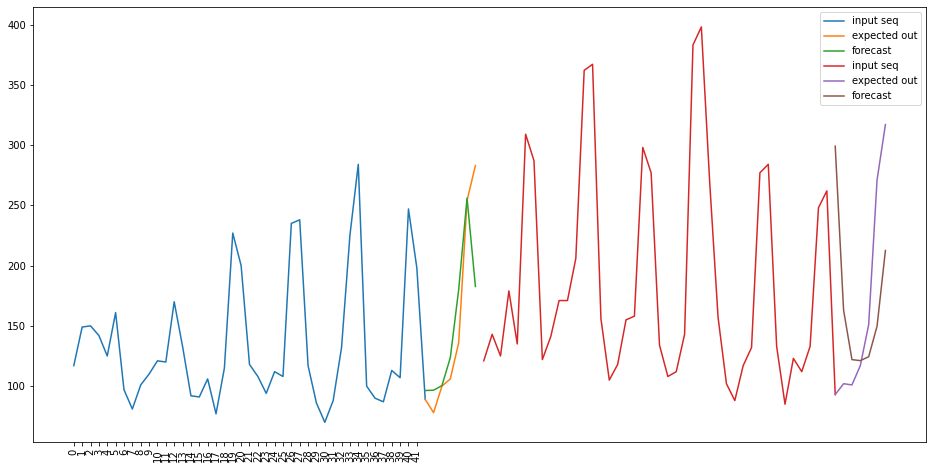

In [66]:
def sliding_prediction_graph(in_len=42, out_len=7, f_steps=f_steps):
    test_input = (mono_inp_te[:,:,0]*std)+mean
    test_output = (mono_out_te[:,:,0]*std)+mean
    predictions = (mono_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean
    print(f_steps, test_input.shape, test_output.shape, predictions.shape)

    idx=0
    plt.figure(figsize=(16,8))
    #plt.plot(range(0,test.shape[0]), test.qty, label="raw")
    while idx <= len(test-in_len):
    #for idx, t_i in enumerate(test_input):
        input_plot = np.append(test_input[idx], test_output[idx][0])
        test_out_plot = test_output[idx]
        print(input_plot, test_out_plot)
        expected_output = test_output[idx]
        forecasted_out = predictions[0+idx:7+idx]
        plt.plot(range(idx, in_len+idx+1), input_plot, label="input seq")
        plt.plot(range(in_len+idx, in_len+idx+out_len), test_out_plot, label="expected out")
        plt.plot(range(in_len+idx,in_len+out_len+idx), forecasted_out, label="forecast")
        plt.xticks(range(0,in_len), rotation=90)
        plt.legend()
        idx += in_len+out_len
    plt.show()
    
sliding_prediction_graph()